### Libraries

In [1310]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
import itertools


#ML Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

#Tensorflow
import tensorflow as tf
from keras.layers import LSTM, Dense, InputLayer
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.losses import MeanAbsoluteError
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError



warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .60,
        "validationSize": .20,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    },
    "lstm":{
        "epochs": 20,
        "batch_size": 64,
        "lr": 0.0001
    }
}

In [1311]:
def plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=y_train, mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_val_dates, y=y_val, mode="lines", name="Validation"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=y_test, mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (kWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.write_image("../results/dataset_split.png", width=1000, scale=2, format="png")
    fig.show()

In [1312]:
def plotPredictions(dates, y_pred, y_test, filename=None):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    if filename is not None:
        fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

In [1313]:
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)

    mae_ref = mean_absolute_error(np.exp(y_test), np.exp(y_pred))

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted)

        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(np.exp(y_test), np.exp(y_pred_permuted))

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()

In [1314]:
def calculate_metrics(y_true, y_pred):    
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)
    # RMSE (Root Mean Squared Error)
    rmse = root_mean_squared_error(y_true, y_pred)
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    # MDAPE (Median Absolute Percentage Error)
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    
    return mae, rmse, mape, mdape

def plot_mae_rmse_metrics(train_rmse, validation_rmse, train_mae, validation_mae):
    epochs_list = np.arange(0, 50)
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_rmse, name="Training RMSE", mode="lines")
    trace2 = go.Scatter(x=epochs_list, y=validation_rmse, name="Validation RMSE", mode="lines")
    trace3 = go.Scatter(x=epochs_list, y=train_mae, name="Training MAE", mode="lines")
    trace4 = go.Scatter(x=epochs_list, y=validation_mae, name="Validation MAE", mode="lines")

    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.add_trace(trace3)
    fig.add_trace(trace4)
    fig.update_layout(
        title = "Metrics in Training/Validation",
        xaxis_title = "Epoch",
        yaxis_title = "RMSE / MAE",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

def plot_metrics(train_data, validation_data, train_names, val_names, yaxis_title, parameters):
    epochs_list = np.arange(0, parameters["lstm"]["epochs"])
    fig = go.Figure()
    for train, name in zip(train_data, train_names):
        trace = go.Scatter(x = epochs_list, y=train, name=name, mode="lines")
        fig.add_trace(trace)
    for validation, name in zip(validation_data, val_names):
        trace = go.Scatter(x = epochs_list, y=validation, name=name, mode="lines")
        fig.add_trace(trace)

    fig.update_layout(
        title = "Metrics in Training/Validation",
        xaxis_title = "Epoch",
        yaxis_title = yaxis_title,
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()
    

In [1315]:
def plotLosses(train_loss, validation_loss):
    epochs_list = np.arange(0, 50)
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_loss, name="Training Loss", mode="lines")
    trace2 = go.Scatter(x=epochs_list, y=validation_loss, name="Validation Loss", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title = "Training and Validation Losses",
        xaxis_title = "Epoch",
        yaxis_title = "MSE Loss Value",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

In [1316]:
#Create LSTM Model
from keras import ops
def create_LSTM_Model(num_features, n_units, n_layers, dropout):
    model = Sequential()
    model.add(InputLayer((num_features, 1)))
    for _ in range(n_layers - 1):
        model.add(LSTM(units=n_units, activation='tanh',kernel_initializer='glorot_normal', return_sequences=True, dropout=dropout))
    model.add(LSTM(units=n_units, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='linear'))
    return model

def mdape_fn(y_true, y_pred):
    epsilon = np.finfo(np.float32).eps
    ape = ops.abs((y_true - y_pred) / ops.maximum(ops.abs(y_true), epsilon))
    return ops.median(ape) * 100


def train_model(model, X, y, parameters, validation_data=None, verbose=False):
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()
    if not isinstance(y, np.ndarray):
        y = y.to_numpy()
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y = y.reshape((y.shape[0], 1))
    model.compile(
        loss = "mse", 
        optimizer=Adam(learning_rate=parameters["lstm"]["lr"]), 
        metrics=[
            MeanAbsoluteError(),
            RootMeanSquaredError(),
            MeanAbsolutePercentageError(),
            mdape_fn
        ]
    )
    if validation_data is not None:
        return model.fit(
            X, 
            y, 
            epochs=parameters["lstm"]["epochs"],
            batch_size = parameters["lstm"]["batch_size"],
            validation_data = (validation_data[0], validation_data[1]),
            verbose=verbose
        )
    else:
        return model.fit(
            X, 
            y, 
            epochs=parameters["lstm"]["epochs"],
            batch_size = parameters["lstm"]["batch_size"],
            verbose=verbose
        )

In [1317]:
def addNLags(df, lags_list):
    lag_df = df.copy()
    for lag in lags_list:
        lag_df[f'lag_{lag}'] = lag_df["Demanda_kWh"].shift(lag * 24)

    return lag_df.fillna(0)

def parseData(df):
    for col in df:
        df[col] = df[col].astype(float)
    return df

def normalizeData(data):
    df = data.copy()
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

def inverse_boxcox(y, lambda_):
    if lambda_ != 0:
        return np.exp(np.log(y * lambda_ + 1) / lambda_)
    else:
        return np.exp(y)

### Split Dataset

In [1318]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)
df = df.drop(columns=["Date"], axis=1)

df = parseData(df)
df.columns = df.columns.map(str)

y = df["Demanda_kWh"]

X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)

col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Validation Size:{len(X_val)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12046
Training Size:7228
Validation Size:2410
Test Size: 2410


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday'],
      dtype='object')

In [1319]:
plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test)

## Machine Learning Models

### KNN

In [1320]:
knn = KNeighborsRegressor(n_neighbors=20, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
mae, rmse, mape, mdape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MdAPE: {mdape}")

MAE: 2.2638570561401306, RMSE: 3.662615782245616, MAPE: 54.15852975673992, MdAPE: 33.00814202656867


In [1321]:
plotPredictions(X_test_dates, y_pred, y_test)

In [1322]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

In [1323]:
plotPredictions(X_test_dates[:7*24], y_pred[:7*24], y_test[:7*24])

### LightGBM

In [1324]:
lgbm = LGBMRegressor(objective="regression", boosting_type='gbdt', n_estimators=1000, learning_rate=0.01, random_state=123, n_jobs=-1, early_stopping_rounds=100, verbose=100)
lgbm.fit(X_train, y_train, eval_metric="mae", eval_set=[(X_val, y_val)])
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)
mae, rmse, mape, mdape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MdAPE: {mdape}")

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.259519
[LightGBM] [Debug] init for col-wise cost 0.000003 seconds, init for row-wise cost 0.000580 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1088
[LightGBM] [Info] Number of data points in the train set: 7228, number of used features: 11
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 5.460738
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debu

In [1325]:
plotPredictions(X_test_dates, y_pred, y_test)

In [1326]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

### XGBoost

In [1327]:
xgboost = XGBRegressor(n_estimators=1000, random_state=123, learning_rate=0.03, max_depth=7, verbose=0)
xgboost.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
           eval_metric='mae', 
           early_stopping_rounds=100)
y_pred = xgboost.predict(X_test)
mae, rmse, mape, mdape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MdAPE: {mdape}")

[0]	validation_0-mae:4.37113
[1]	validation_0-mae:4.33332
[2]	validation_0-mae:4.29581
[3]	validation_0-mae:4.26153
[4]	validation_0-mae:4.22734
[5]	validation_0-mae:4.19444
[6]	validation_0-mae:4.16230
[7]	validation_0-mae:4.13320
[8]	validation_0-mae:4.10265
[9]	validation_0-mae:4.07611
[10]	validation_0-mae:4.04755
[11]	validation_0-mae:4.02119
[12]	validation_0-mae:3.99470
[13]	validation_0-mae:3.96997
[14]	validation_0-mae:3.94493
[15]	validation_0-mae:3.92040
[16]	validation_0-mae:3.89835
[17]	validation_0-mae:3.87507
[18]	validation_0-mae:3.85779
[19]	validation_0-mae:3.84008
[20]	validation_0-mae:3.82254
[21]	validation_0-mae:3.80780
[22]	validation_0-mae:3.79028
[23]	validation_0-mae:3.77483
[24]	validation_0-mae:3.76059
[25]	validation_0-mae:3.74751
[26]	validation_0-mae:3.73578
[27]	validation_0-mae:3.72190
[28]	validation_0-mae:3.71097
[29]	validation_0-mae:3.69828
[30]	validation_0-mae:3.68335
[31]	validation_0-mae:3.67399
[32]	validation_0-mae:3.65998
[33]	validation_0-ma

In [1328]:
plotPredictions(X_test_dates, y_pred, y_test)

In [1329]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

### Long Short-Term Memory (LSTM)

In [1330]:
lstm = create_LSTM_Model(
    num_features = X_train.shape[1], 
    n_units = 64, 
    n_layers = 2, 
    dropout = 0.2) 
lstm.summary()

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_94 (LSTM)                  │ (None, 11, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_95 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [1331]:
train_history = train_model(
    model = lstm, 
    X = X_train, 
    y = y_train, 
    parameters = parameters,
    validation_data = (X_val, y_val),
    verbose = True)

y_pred = lstm.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
).flatten()

mae, rmse, mape, mdape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MdAPE: {mdape}")

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 52.8389 - mdape_fn: 87.7225 - mean_absolute_error: 4.9577 - mean_absolute_percentage_error: 87.9131 - root_mean_squared_error: 7.2613 - val_loss: 46.9205 - val_mdape_fn: 56.4220 - val_mean_absolute_error: 3.9733 - val_mean_absolute_percentage_error: 67.2602 - val_root_mean_squared_error: 6.8499
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 34.7053 - mdape_fn: 69.4626 - mean_absolute_error: 3.7055 - mean_absolute_percentage_error: 72.7775 - root_mean_squared_error: 5.8875 - val_loss: 47.0348 - val_mdape_fn: 67.5229 - val_mean_absolute_error: 4.1962 - val_mean_absolute_percentage_error: 80.2375 - val_root_mean_squared_error: 6.8582
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 30.6042 - mdape_fn: 68.6016 - mean_absolute_error: 3.4820 - mean_absolute_percentage_error: 73.0171 - root_mean_squared_error: 5.5286 - val_loss: 47.9786 - val_mdape_fn: 68.1442 - val_mean_absolute_error: 4.1628 - val_mean_ab

In [1332]:
plotPredictions(X_test_dates, y_pred, y_test)

In [1333]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

In [1334]:
plotLosses(train_history.history["loss"], train_history.history["val_loss"])

In [1335]:
# MAE and RMSE
plot_metrics(
    train_data = [train_history.history["root_mean_squared_error"], train_history.history["mean_absolute_error"]], 
    validation_data = [train_history.history["val_root_mean_squared_error"], train_history.history["val_mean_absolute_error"]], 
    train_names = ["Training RMSE", "Training MAE"],
    val_names = ["Validation RMSE", "Validation MAE"],
    yaxis_title = "RMSE / MAE",
    parameters = parameters
)

In [1336]:
# MAPE and MdAPE
plot_metrics(
    train_data = [train_history.history["mean_absolute_percentage_error"], train_history.history["mdape_fn"]], 
    validation_data = [train_history.history["val_mean_absolute_percentage_error"], train_history.history["val_mdape_fn"]], 
    train_names = ["Training MAPE", "Training MdAPE"],
    val_names = ["Validation MAPE", "Validation MdAPE"],
    yaxis_title = "MAPE / MdAPE",
    parameters = parameters
)

### List of Models to Test

In [1337]:
models, models_names = [], []

#Tree Models
model_LGBM = LGBMRegressor(boosting_type='gbdt', n_estimators=1000, learning_rate=0.01, random_state=123, n_jobs=-1, verbose=0)
model_XGB = XGBRegressor(n_estimators=1000, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
models.append(model_LGBM)
models_names.append("LGBM_1000")
models.append(model_XGB)
models_names.append("XGB_1000")

#K-NN Model
model_KNN = KNeighborsRegressor(n_neighbors=15, weights='uniform')
models.append(model_KNN)
models_names.append("KNNr_15")

#LSTM Model
model_LSTM = create_LSTM_Model(X_train.shape[1], 64, 1, 0.2)
models.append(model_LSTM)
models_names.append("LSTM")


### Benchmark Transformations

In [1338]:
def benchmarkTransformations(models, models_names, X, y, trainingSize):

    results = pd.DataFrame(columns=["Model", "RMSE", "MAE", "MAPE", "MdAPE","RMSE Log", "MAE Log", "MAPE Log", "MdAPE Log", "RMSE Boxcox", "MAE Boxcox", "MAPE Boxcox", "MdAPE Boxcox", "RMSE SQRT", "MAE SQRT", "MAPE SQRT", "MdAPE SQRT"])
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_train, y_train = X.iloc[:trainingSize, :].copy(deep=True), y.iloc[:trainingSize].copy(deep=True)
        X_test, y_test = X.iloc[trainingSize:, :].copy(deep=True), y.iloc[trainingSize:].copy(deep=True)
        
        # No transformation
        if "LSTM" in model_name or "GRU" in model_name:
            train_model(model, X_train, y_train, parameters)
            y_pred = model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            mae, rmse, mape, mdape = calculate_metrics(y_test, y_pred)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae, rmse, mape, mdape = calculate_metrics(y_test, y_pred)
        
        # Logaritmic Transformation
        log_model = model
        if "LSTM" in model_name or "GRU" in model_name:
            train_model(log_model, X_train, np.log1p(y_train), parameters)
            y_log_pred = log_model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            y_log_pred = np.expm1(y_log_pred)
            mae_log, rmse_log, mape_log, mdape_log = calculate_metrics(y_test, y_log_pred)
        else:
            log_model.fit(X_train, np.log1p(y_train))
            y_log_pred = log_model.predict(X_test)
            y_log_pred = np.expm1(y_log_pred)
            mae_log, rmse_log, mape_log, mdape_log = calculate_metrics(y_test, y_log_pred)

        # Box-Cox Transformation
        y_train_boxcox, lambda_optima = boxcox(y_train)
        boxcox_model = model
        if "LSTM" in model_name or "GRU" in model_name:
            train_model(boxcox_model, X_train, y_train_boxcox, parameters)
            y_bc_pred = boxcox_model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            y_bc_pred = inverse_boxcox(y_bc_pred, lambda_optima)
            mae_boxcox, rmse_boxcox, mape_boxcox, mdape_boxcox = calculate_metrics(y_test, y_bc_pred)
        else:
            boxcox_model.fit(X_train, y_train_boxcox)
            y_bc_pred = boxcox_model.predict(X_test)
            y_bc_pred = inverse_boxcox(y_bc_pred, lambda_optima)
            mae_boxcox, rmse_boxcox, mape_boxcox, mdape_boxcox = calculate_metrics(y_test, y_bc_pred)

        # Squared Root Transformation
        y_train_sqrt = np.sqrt(y_train)
        sqrt_model = model
        if "LSTM" in model_name or "GRU" in model_name:
            train_model(sqrt_model, X_train, y_train_sqrt, parameters)
            y_sqrt_pred = sqrt_model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            y_sqrt_pred = y_sqrt_pred ** 2
            mae_sqrt, rmse_sqrt, mape_sqrt, mdape_sqrt = calculate_metrics(y_test, y_sqrt_pred)
        else:
            sqrt_model.fit(X_train, y_train_sqrt)
            y_sqrt_pred = sqrt_model.predict(X_test)
            y_sqrt_pred = y_sqrt_pred ** 2
            mae_sqrt, rmse_sqrt, mape_sqrt, mdape_sqrt = calculate_metrics(y_test, y_sqrt_pred)

        print(f"{model_name} => DONE")
        #Save Results
        results.loc[len(results.index)] = [model_name, rmse, mae, mape, mdape, rmse_log, mae_log, mape_log, mdape_log, rmse_boxcox, mae_boxcox, mape_boxcox, mdape_boxcox, rmse_sqrt, mae_sqrt, mape_sqrt, mdape_sqrt]
        
    return results

In [1339]:
benchmark = benchmarkTransformations(models, models_names, X, y, validationSize)
benchmark.to_csv("../results/benchmark_transformations.csv")

 25%|██▌       | 1/4 [00:06<00:19,  6.58s/it]

LGBM_1000 => DONE


 50%|█████     | 2/4 [00:13<00:13,  6.83s/it]

XGB_1000 => DONE


 75%|███████▌  | 3/4 [00:13<00:03,  3.86s/it]

KNNr_15 => DONE
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


100%|██████████| 4/4 [02:15<00:00, 33.94s/it]

LSTM => DONE


In [1340]:
benchmark = benchmark.to_markdown(index=False)
print(benchmark)

| Model     |    RMSE |     MAE |    MAPE |   MdAPE |   RMSE Log |   MAE Log |   MAPE Log |   MdAPE Log |   RMSE Boxcox |   MAE Boxcox |   MAPE Boxcox |   MdAPE Boxcox |   RMSE SQRT |   MAE SQRT |   MAPE SQRT |   MdAPE SQRT |
|:----------|--------:|--------:|--------:|--------:|-----------:|----------:|-----------:|------------:|--------------:|-------------:|--------------:|---------------:|------------:|-----------:|------------:|-------------:|
| LGBM_1000 | 3.04353 | 1.71436 | 37.2468 | 26.8308 |    3.11402 |   1.50681 |    27.1815 |     19.116  |       3.31368 |      1.49763 |       23.2282 |        16.5564 |     3.06085 |    1.57537 |     30.5402 |      20.9553 |
| XGB_1000  | 3.17302 | 1.77664 | 38.6916 | 24.6203 |    3.21489 |   1.56332 |    28.235  |     20.4617 |       3.37943 |      1.54111 |       24.1715 |        17.1677 |     3.1614  |    1.63531 |     32.3602 |      22.2674 |
| KNNr_15   | 3.81784 | 2.40895 | 59.5633 | 32.3863 |    3.6455  |   2.06212 |    43.506  |     

### Lags as Predictors

In [1341]:
def gridSearchLags(df, lags_combinations, trainingSize):
    y = df["Demanda_kWh"]
    X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
        "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
        "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
        "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
        "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)    
    X_train, y_train = X.iloc[:trainingSize, :].copy(deep=True), y.iloc[:trainingSize].copy(deep=True)
    X_test, y_test = X.iloc[trainingSize:, :].copy(deep=True), y.iloc[trainingSize:].copy(deep=True)
    results = pd.DataFrame(columns=["Lags", "MAE_Test", "RMSE_Test", "MAPE_Test", "MdAPE_Test"])
    model = XGBRegressor(n_estimators=1300, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, rmse, mape, mdape = calculate_metrics(y_test, y_pred)
    results.loc[len(results.index)] = [[0], mae, rmse, mape, mdape]

    for lags in tqdm(lags_combinations, total=len(lags_combinations)):
        df_copy = df.copy(deep=True)
        df_copy = addNLags(df_copy, lags)
        y = df_copy["Demanda_kWh"]
        X = df_copy.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
            "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
            "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
            "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
            "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
        X_train, y_train = X.loc[:trainingSize, :].copy(deep=True), y.loc[:trainingSize].copy(deep=True)
        X_test, y_test = X.loc[trainingSize:, :].copy(deep=True), y.loc[trainingSize:].copy(deep=True)
        model = XGBRegressor(n_estimators=1300, random_state=123, learning_rate=0.01, max_depth=7, verbose=0)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae, rmse, mape, mdape = calculate_metrics(y_test, y_pred)
        results.loc[len(results.index)] = [lags, mae, rmse, mape, mdape]

    best_mae_index = results["MAE_Test"].idxmin()
    best_rmse_index = results["RMSE_Test"].idxmin()
    best_mape_index = results["MAPE_Test"].idxmin()
    best_mdape_index = results["MdAPE_Test"].idxmin()
    best_mae_lags = results.loc[best_mae_index, "Lags"]
    best_rmse_lags = results.loc[best_rmse_index, "Lags"]
    best_mape_lags = results.loc[best_mape_index, "Lags"]
    best_mdape_lags = results.loc[best_mdape_index, "Lags"]
    print(f"Mejor combinación de lags basada en MAE: {best_mae_lags} con MAE: {results.loc[best_mae_index, 'MAE_Test']}")
    print(f"Mejor combinación de lags basada en RMSE: {best_rmse_lags} con RMSE: {results.loc[best_rmse_index, 'RMSE_Test']}")
    print(f"Mejor combinación de lags basada en MAPE: {best_mape_lags} con MAPE: {results.loc[best_mape_index, 'MAPE_Test']}")
    print(f"Mejor combinación de lags basada en MdAPE: {best_mdape_lags} con MdAPE: {results.loc[best_mdape_index, 'MdAPE_Test']}")

    return results, best_mae_lags

In [1342]:
lags_combinations = []
possible_lags = [1, 2, 3]

for i in range(1, len(possible_lags) + 1):
    lags_combinations.extend(itertools.combinations(possible_lags, i))
lags_combinations = [list(combo) for combo in lags_combinations]

In [1343]:
results, best_lags_comb = gridSearchLags(df.copy(deep=True), lags_combinations, validationSize)
results = results.to_markdown(index=False)
print(results)

100%|██████████| 7/7 [00:35<00:00,  5.02s/it]

Mejor combinación de lags basada en MAE: [1, 2] con MAE: 1.599804161501278
Mejor combinación de lags basada en RMSE: [1, 2] con RMSE: 2.87889530268464
Mejor combinación de lags basada en MAPE: [1, 2] con MAPE: 34.71504423182276
Mejor combinación de lags basada en MdAPE: [1, 2] con MdAPE: 23.136407136917114
| Lags      |   MAE_Test |   RMSE_Test |   MAPE_Test |   MdAPE_Test |
|:----------|-----------:|------------:|------------:|-------------:|
| [0]       |    1.7818  |     3.18181 |     38.8617 |      24.9435 |
| [1]       |    1.69716 |     2.9678  |     36.9187 |      23.5335 |
| [2]       |    1.71897 |     3.06269 |     37.0947 |      24.0775 |
| [3]       |    1.70768 |     3.06551 |     36.7572 |      24.383  |
| [1, 2]    |    1.5998  |     2.8789  |     34.715  |      23.1364 |
| [1, 3]    |    1.64842 |     2.94796 |     35.4092 |      23.6968 |
| [2, 3]    |    1.69605 |     3.00345 |     36.6882 |      24.8289 |
| [1, 2, 3] |    1.62141 |     2.89131 |     35.2653 |      24

In [1344]:
best_lags_comb

[1, 2]

In [1355]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)
df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)
df = addNLags(df, [1, 2, 5, 7])
df = df.drop(columns=["Date"], axis=1)
df = parseData(df)
df.columns = df.columns.map(str)

y = df["Demanda_kWh"]
X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12046
Training Size:7228
Test Size: 2410


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday', 'lag_1', 'lag_2', 'lag_5', 'lag_7'],
      dtype='object')

In [1356]:
models, models_names = [], []

#Tree Models
model_LGBM = LGBMRegressor(boosting_type='gbdt', n_estimators=1000, learning_rate=0.01, random_state=123, n_jobs=-1, verbose=0)
model_XGB = XGBRegressor(n_estimators=1000, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
models.append(model_LGBM)
models_names.append("LGBM_1000")
models.append(model_XGB)
models_names.append("XGB_1000")

#K-NN Model
model_knn = KNeighborsRegressor(n_neighbors=15, weights='uniform')
models.append(model_knn)
models_names.append("KNNr_15")

#LSTM Model
model_lstm = create_LSTM_Model(X_train.shape[1], 64, 1, 0.2)
models.append(model_lstm)
models_names.append("LSTM")

### Walking Forward Validation

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*lmUY2pKwxu5kwA1II6yAbQ.png" width=600px></img>
</div>


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:12<00:36, 12.29s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.5526946514960545, RMSE: 3.1177338878170002, MAPE: 0.273788190840661


 50%|█████     | 2/4 [00:22<00:21, 10.78s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.5160877893754652, RMSE: 3.090850659040101, MAPE: 0.26876335081046404


 75%|███████▌  | 3/4 [00:22<00:06,  6.05s/it]

Model: KNNr_15 ===> Mean Test MAE: 2.0590589663191667, RMSE: 3.7024774317076865, MAPE: 0.4137711590407469
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|██████████| 4/4 [01:51<00:00, 27.84s/it]

Model: LSTM ===> Mean Test MAE: 2.6241245044047785, RMSE: 15.240263716583074, MAPE: 0.5255153852934266


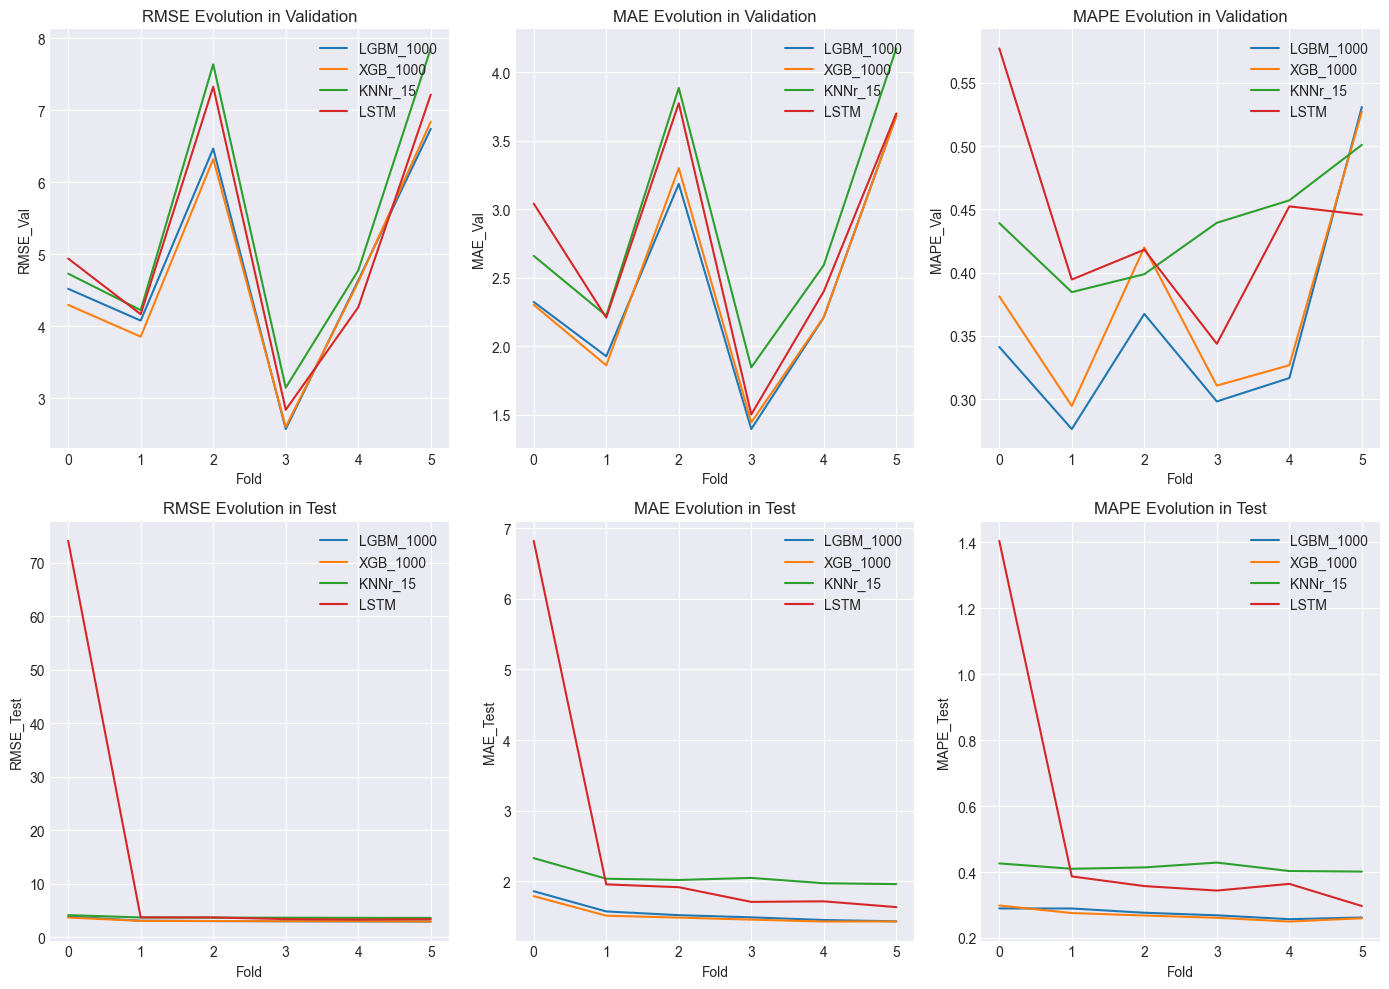

In [1347]:
def walkForwardValidation(X, y, X_test, y_test, models, models_names, params, plot=False, fixed_train=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val", "MAPE_Test", "MAPE_Val", "Mean_MRSE_Test", "Mean_MAE_Test", "Mean_MAPE_Test","Mean_RMSE_Val", "Mean_MAE_Val", "Mean_MAPE_Val"])
    y_test = np.expm1(y_test)
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        if fixed_train:
            tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=X.shape[0] // n_splits)
        else:
            tscv = TimeSeriesSplit(n_splits=n_splits)
        rmse_test, rmse_val, mae_test, mae_val, mape_test, mape_val = [], [], [], [], [], []
        for train_index, eval_index in tscv.split(X):
            X_train, X_val = X[train_index], X[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            y_val = np.expm1(y_val)

            if "LSTM" in model_name or "GRU" in model_name:
                train_model(model, X_train, y_train, parameters)
                y_pred_val = model.predict(
                    x = X_val,
                    batch_size = parameters["lstm"]["batch_size"]
                ).flatten()
            else:
                model.fit(X_train, y_train)
                y_pred_val = model.predict(X_val)

            y_pred_val = np.expm1(y_pred_val)
            mae_val.append(mean_absolute_error(y_val, y_pred_val))
            rmse_val.append(root_mean_squared_error(y_val, y_pred_val))
            mape_val.append(mean_absolute_percentage_error(y_val, y_pred_val))

            #Test Scores
            if "LSTM" in model_name or "GRU" in model_name:
                y_pred_test = model.predict(
                    x = X_test,
                    batch_size = parameters["lstm"]["batch_size"]
                ).flatten()
            else:
                y_pred_test = model.predict(X_test)

            #Calculate Metrics
            y_pred_test = np.expm1(y_pred_test)
            mae_test.append(mean_absolute_error(y_test, y_pred_test))
            rmse_test.append(root_mean_squared_error(y_test, y_pred_test))
            mape_test.append(mean_absolute_percentage_error(y_test, y_pred_test))

            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}, MAPE: {np.mean(mape_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, mape_test, mape_val, np.mean(rmse_test), np.mean(mae_test), np.mean(mape_test), np.mean(rmse_val), np.mean(mae_val), np.mean(mape_val)] 
    
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "MAPE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test", "MAPE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "MAPE_Val", "RMSE_Test", "MAE_Test", "MAPE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
        for i in range(6):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            for _, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend(loc='upper right')
            ax.grid(True)
        if fixed_train:
            plt.savefig('../results/Sliding_Window_Validation_plot.png')
        else:
            plt.savefig('../results/Walking_Forward_Validation_plot.png')
        plt.tight_layout()
        plt.show()
    return results

results = walkForwardValidation(np.concatenate([X_train.to_numpy(), X_val.to_numpy()], axis=0), np.concatenate([y_train.to_numpy(), y_val.to_numpy()], axis=0), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=False)

### Sliding Window Validation

<div align="center">
    <img src="https://i.sstatic.net/QNlQl.png" width=600px>
</div>

 25%|██▌       | 1/4 [00:05<00:17,  5.83s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.836983579725809, RMSE: 3.600484294903998, MAPE: 0.36351808633067034


 50%|█████     | 2/4 [00:13<00:14,  7.05s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.7614251835107515, RMSE: 3.4016261799702487, MAPE: 0.35032998569741003


 75%|███████▌  | 3/4 [00:14<00:04,  4.12s/it]

Model: KNNr_15 ===> Mean Test MAE: 2.202741887358876, RMSE: 3.8594177123578817, MAPE: 0.45650471652866775
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 4/4 [01:02<00:00, 21.33s/it]

Model: LSTM ===> Mean Test MAE: 1.7452307922947465, RMSE: 3.379022406526485, MAPE: 0.35293731089155694


100%|██████████| 4/4 [01:02<00:00, 15.52s/it]


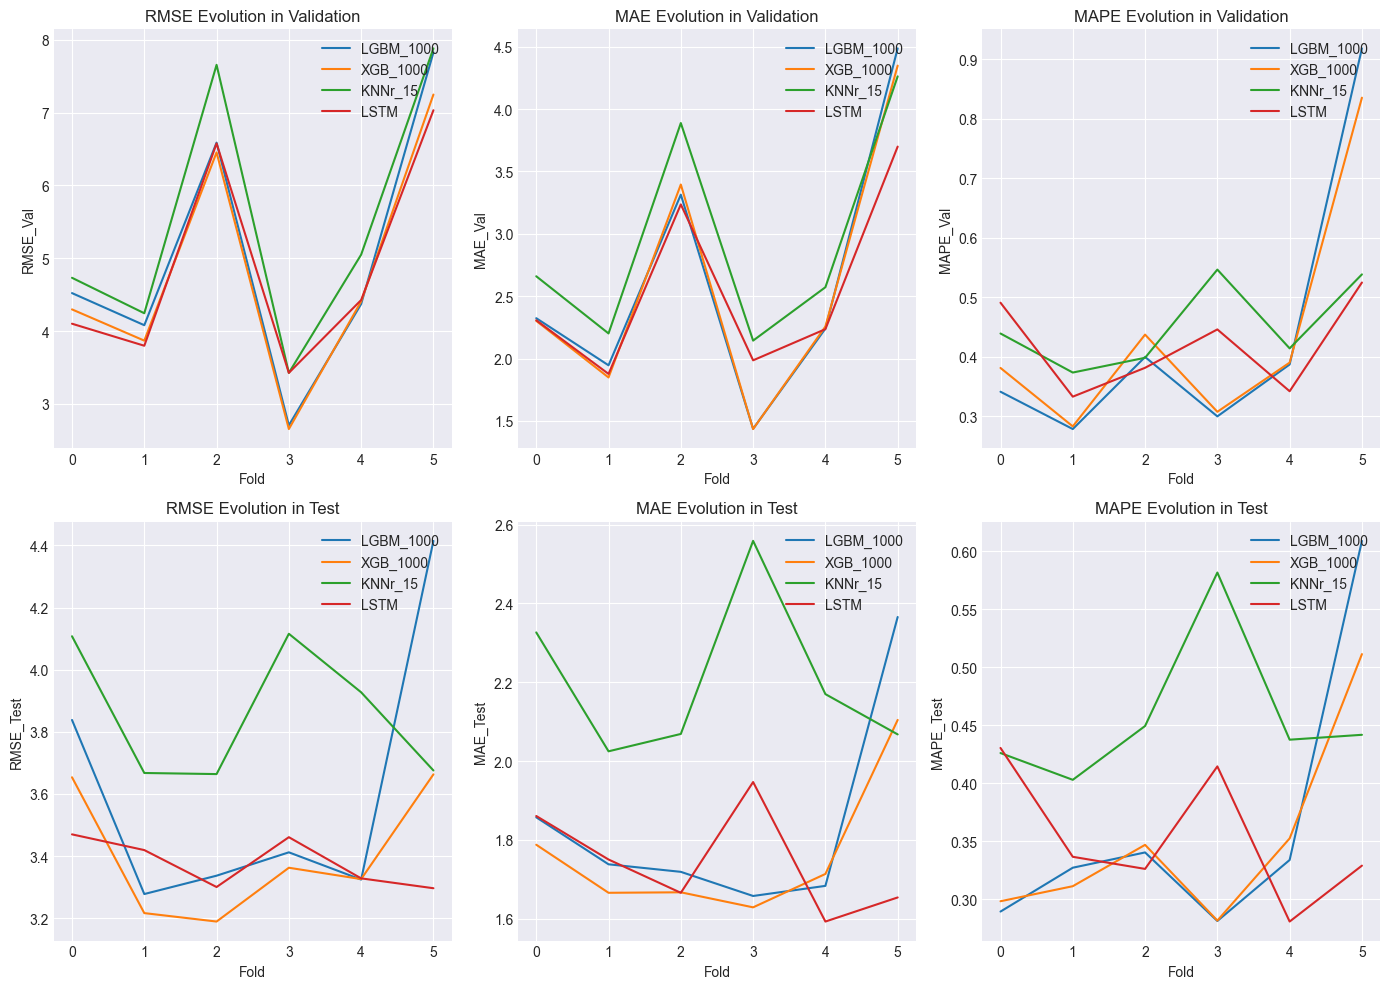

In [1348]:
results = walkForwardValidation(np.concatenate([X_train.to_numpy(), X_val.to_numpy()], axis=0), np.concatenate([y_train.to_numpy(), y_val.to_numpy()], axis=0), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=True)

### Grid Search (XGBOOST)

In [1349]:
paramsXGB = {
    'max_depth': [7, 8, 9],
    'learning_rate': [0.01, 0.005, 0.003],
    'gamma': [7, 8, 9],
    'colsample_bytree' : [0.7, 0.9, 1],
    'colsample_bynode': [ 0.7, 0.9, 1],
    'n_estimators': [1300]
}

def gridSearchXGB(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        max_depth = param.get('max_depth')
        n_estimators = param.get('n_estimators')
        lr = param.get('learning_rate')
        gamma = param.get('gamma')
        colsample_bytree = param.get('colsample_bytree')
        colsample_bynode = param.get('colsample_bynode')
        regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=n_estimators, learning_rate = lr, max_depth=max_depth, colsample_bytree = colsample_bytree, colsample_bynode = colsample_bynode, gamma=gamma, random_state=123)

        regressorXGBR.fit(
            X = np.concatenate([X_train, X_val], axis=0),
            y = np.concatenate([y_train, y_val], axis=0),
            verbose=0
        )  
        y_pred = regressorXGBR.predict(X_test)
        
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Max_depth: {max_depth}, Gamma: {gamma}, Col_Sample_By_Tree: {colsample_bytree}, Col_Sample_By_Node: {colsample_bynode}")
    config["mae"] = best_mae
    return config

#gridSearchXGB(paramsXGB)

### Grid Search (LightGBM)

In [1350]:
params = {
    'num_leaves': [10, 20, 30, 40],
    'learning_rate': [0.05, 0.01, 0.005],
    'colsample_bytree' : [0.7, 0.9, 1],
    'n_estimators': [1200],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
}

def gridSearchLGBM(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        n_estimators = param.get('n_estimators')
        num_leaves = param.get('num_leaves')
        lr = param.get('learning_rate')
        reg_alpha = param.get('reg_alpha')
        colsample_bytree = param.get('colsample_bytree')
        LGBMReg = LGBMRegressor(boosting_type='gbdt', n_estimators=n_estimators, learning_rate=lr, random_state=123, reg_alpha=reg_alpha, n_jobs=-1, verbose=-1, num_leaves=num_leaves) 
        LGBMReg.fit(
            X = np.concatenate([X_train, X_val], axis=0),
            y = np.concatenate([y_train, y_val], axis=0),
        )  
        y_pred = LGBMReg.predict(X_test)
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Num_leaves: {num_leaves}, Col_Sample_By_Tree: {colsample_bytree}, reg_alpha: {reg_alpha}")
    config["mae"] = best_mae
    return config
#gridSearchLGBM(params)

### Feature Importance 

In [1359]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1300, learning_rate = 0.01, max_depth=9, colsample_bytree = .7, colsample_bynode = 0.7, gamma=7, random_state=123)
regressorXGBR.fit(
    X = np.concatenate([X_train, X_val], axis=0),
    y = np.concatenate([y_train, y_val], axis=0),
    verbose=0
)

y_pred = regressorXGBR.predict(X_test)
mae, rmse, mape, mdape = calculate_metrics(np.expm1(y_test), np.expm1(y_pred))
print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MdAPE: {mdape}")

imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=col_names, columns=['importance'])
imp_df.sort_values(by=["importance"])

MAE: 1.2855831737217698, RMSE: 2.986485270734437, MAPE: 18.854249774210714, MdAPE: 9.525999252250168


,importance
temperature_2m_C,0.024879
Month_cos,0.036134
isWeekend,0.038009
lag_5,0.038094
Hour_sin,0.042045
DayOfWeek_sin,0.043396
isHoliday,0.045444
diffuse_radiation_W/m2,0.046102
direct_normal_irradiance_W/m2,0.046908
lag_2,0.054776


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 80.40it/s]


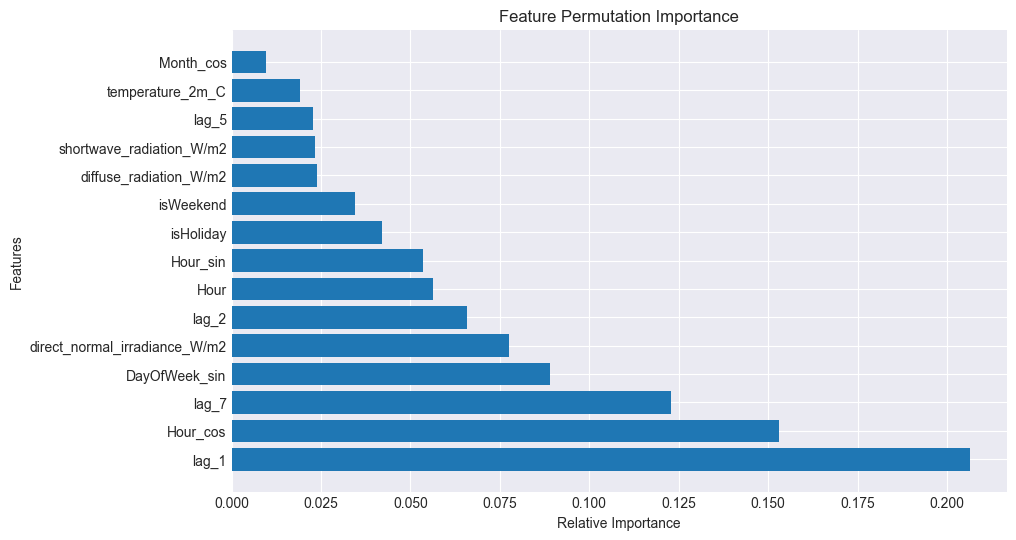

In [1360]:
permutation_feature_importance(regressorXGBR, X_test.to_numpy(), y_test, np.array(col_names))

### Plot Prediction Results

In [1361]:
plotPredictions(X_test_dates, np.expm1(y_pred), np.expm1(y_test), "predictions_Test_All")

In [1362]:
plotPredictions(X_test_dates[:30*24], np.expm1(y_pred[:30*24]), np.expm1(y_test[:30*24]), "predictions_Test_Month")

In [1363]:
plotPredictions(X_test_dates[:24*7], np.expm1(y_pred[:24*7]), np.expm1(y_test[:24*7]), "predictions_Test_Week")

In [1364]:
print(f"Test Demand Min: {np.min(np.expm1(y_test))} - Max: {np.max(np.expm1(y_test))}")
print(f"Predicted Demand Min: {np.min(np.expm1(y_pred))} - Max: {np.max(np.expm1(y_pred))}")

Test Demand Min: 2.0000000000000004 - Max: 32.000954760000006
Predicted Demand Min: 1.8950858116149902 - Max: 17.69460678100586
